# **ABSTRACT**

The purpose of the current notebook is to build a model capable to predict a song's popularity rating based on other song variables. The dataset used is obtained from the following website 

https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

# **IMPORT LIBRARIES AND LOAD DATA**

In [338]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
import IPython
import sklearn as skl
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, median_absolute_error, max_error
import sweetviz
import tqdm
from tqdm import tqdm

In [339]:
path = './music.csv'
df = pd.read_csv(path, sep = ',', index_col=0)
display(df.head(5))
df.shape

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


(114000, 20)

# **MISSING AND DUPLICATE VALUES**

In [340]:
# Search for unique and missing values
display(df.nunique().to_frame().T.set_index(pd.Index(['unique_value_count'])))
df.isnull().sum().to_frame().T.set_index(pd.Index(['missing_value_count']))

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
unique_value_count,89741,31437,46589,73608,101,50697,2,1174,2083,12,19480,2,1489,5061,5346,1722,1790,45653,5,114


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
missing_value_count,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [341]:
df[df.isnull().any(axis = 1)]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


There is only one row with missing values in the entire dataset, and those missing values correspond to variables 'artists', 'album_name' and 'track_name'. As these variables probably won't be used for the analysis, no action is taken towards the row at hand.

Nevertheless, it seems odd that the number of unique values for the variable 'track_id' does not match the number of rows of the dataset. This is studied below.

In [342]:
# Search for duplicate values
display(df[df.duplicated(keep = 'first')].head())
df[df.duplicated(keep = 'first')].shape


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1925,0CDucx9lKxuCZplLXUz0iX,Buena Onda Reggae Club,Disco 2,Song for Rollins,16,219346,False,0.841,0.577,0,-7.544,1,0.0438,0.238000,0.860000,0.0571,0.843,90.522,4,afrobeat
2155,2aibwv5hGXSgw7Yru8IYTO,Red Hot Chili Peppers,Stadium Arcadium,Snow (Hey Oh),80,334666,False,0.427,0.900,11,-3.674,1,0.0499,0.116000,0.000017,0.1190,0.599,104.655,4,alt-rock
3738,7mULVp0DJrI2Nd6GesLvxn,Joy Division,Timeless Rock Hits,Love Will Tear Us Apart,0,204621,False,0.524,0.902,2,-8.662,1,0.0368,0.000989,0.695000,0.1370,0.907,146.833,4,alternative
4648,6d3RIvHfVkoOtW1WHXmbX3,Little Symphony,Serenity,Margot,27,45714,False,0.269,0.142,0,-23.695,1,0.0509,0.866000,0.904000,0.1140,0.321,67.872,3,ambient
5769,481beimUiUnMUzSbOAFcUT,SUPER BEAVER,突破口 / 自慢になりたい,突破口,54,255080,False,0.472,0.994,8,-1.786,1,0.1140,0.025900,0.000000,0.0535,0.262,103.512,4,anime


(450, 20)

In [343]:
df.drop_duplicates(inplace= True)
print (df.shape)
df[df.duplicated()]

(113550, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


There were 450 duplicate valures in the dataset. which are now dropped, modifying the original dataset.

The only column value that should not be repeated throughtout the current dataset is track_id, as all the other ones are variables that could be repeated between tracks. Therefore, duplicates are looked for considering only the track_id column.

In [346]:
# CELL REFERENCED BELOW

# Get duplicated rows ordered by track ID, so as to identify differences between rows with the same track ID
df_duplicates = df[df.duplicated(subset=['track_id'],keep=False)].sort_values(axis=0, by='track_id')
display (df_duplicates)

# From duplicate dataset preview, it appears the only difference between track_id duplicates is in the column track_genre.
duplicates_set = set()

# Generate a set with track_ids that have duplicates
for row in df_duplicates.index:
    duplicates_set.add(df_duplicates.loc[row].track_id)


# Check if duplicate values differ only in track_genre column. If so, problem_tracks should remain an empty list.
problem_tracks = []

for track_id in tqdm(duplicates_set, desc= 'progress'):
    l = df_duplicates[df_duplicates['track_id'] == track_id].nunique().to_list() # generate a list with the number of unique values for every column of duplicate tracks
    if sum(l[0:-1]) != 19:
        problem_tracks.append(track_id) # There are 20 values in the list, so if the only difference is in track_genre (last column), the sum of the first values should always be 19

len(problem_tracks)    



,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
15028,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4,chill
103211,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4,soul
85578,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1,punk-rock
100420,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1,ska
2106,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.001210,0.000000,0.0995,0.236,148.033,4,alt-rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22326,7zv2vmZq8OjS54BxFzI2wM,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,25,125859,True,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4,death-metal
72679,7zv2vmZq8OjS54BxFzI2wM,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,25,125859,True,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4,metalcore
3100,7zwn1eykZtZ5LODrf7c0tS,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,83,153000,False,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4,alternative
2004,7zwn1eykZtZ5LODrf7c0tS,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,83,153000,False,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4,alt-rock


progress: 100%|██████████| 16299/16299 [02:38<00:00, 102.53it/s]


720

In [347]:
print (len(duplicates_set))
print (len(problem_tracks))

# There are 16299 tracks that appear more than once. 
# From these tracks, 15579 are tracks that appear more than once with different genres. This is, all values are the same except for track_genre
# The other 720 are tracks which differ in another column, though they may also differ in track_genre. Below, it is checked if this column is popularity

tracks_diff_pop = set()

for track_id in problem_tracks:
    df_problem = df_duplicates[df_duplicates['track_id'] == track_id].nunique()
    
    if df_problem['popularity'] != 1 and df_problem['track_genre'] != 1 and sum(df_problem['track_id' : 'track_name']) == 4 and sum(df_problem['duration_ms' : 'time_signature']) == 14:
        tracks_diff_pop.add(track_id)   

print (len(tracks_diff_pop))


16299
720
720


The length of problem_tracks is the same as the length of tracks_diff_pop (720 tracks). This means that the 720 duplicate tracks which differ in columns other than track_genre, actually ONLY differ both in popularity and track genre, but differ in no other column.

In [348]:
# Find the popularity range for the tracks with multiple values of popularity
problem_tracks_dict = {}
for track_id in problem_tracks:
    min_pop = df_duplicates[df_duplicates['track_id'] == track_id].min()['popularity']
    max_pop = df_duplicates[df_duplicates['track_id'] == track_id].max()['popularity']
    problem_tracks_dict[track_id] = max_pop - min_pop

#print (problem_tracks_dict.values())

counter = 0
counter_equal_2 = 0
for i in problem_tracks_dict.values():
    if i > 2:
        counter += 1
    elif i == 2:
        counter_equal_2 += 1

print (f'There are {counter} tracks with a popularity range greater than two points')
print (f'There are {counter_equal_2} tracks with a popularity range of two points')

for track_id in problem_tracks_dict:
    if problem_tracks_dict[track_id] > 2:
        display (df_duplicates [df_duplicates['track_id'] == track_id])

There are 30 tracks with a popularity range greater than two points
There are 17 tracks with a popularity range of two points


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
109219,2ivnsOi3RcEbskFvTS9zt3,Boris Brejcha,Timelapse,Timelapse,18,493440,False,0.819,0.606,2,-10.601,1,0.111,0.000716,0.864,0.111,0.253,125.007,4,techno
73087,2ivnsOi3RcEbskFvTS9zt3,Boris Brejcha,Timelapse,Timelapse,0,493440,False,0.819,0.606,2,-10.601,1,0.111,0.000716,0.864,0.111,0.253,125.007,4,minimal-techno


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
83262,26rzkGV7pXYOIr4hUg8Mbb,Armin van Buuren;Diane Warren;My Marianne,"Feel Again, Pt. 2",Live On Love,0,171733,False,0.631,0.761,10,-6.289,0,0.0708,0.038,0.00001,0.114,0.534,122.698,4,progressive-house
110114,26rzkGV7pXYOIr4hUg8Mbb,Armin van Buuren;Diane Warren;My Marianne,"Feel Again, Pt. 2",Live On Love,3,171733,False,0.631,0.761,10,-6.289,0,0.0708,0.038,0.00001,0.114,0.534,122.698,4,trance


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110105,0BhLfxWA4TwGu8bGVKBotN,Armin van Buuren;Philip Strand,"Feel Again, Pt. 2",Roll The Dice,27,155238,False,0.612,0.731,1,-5.869,0,0.0527,0.057,0.0,0.317,0.569,125.916,4,trance
83260,0BhLfxWA4TwGu8bGVKBotN,Armin van Buuren;Philip Strand,"Feel Again, Pt. 2",Roll The Dice,0,155238,False,0.612,0.731,1,-5.869,0,0.0527,0.057,0.0,0.317,0.569,125.916,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
57723,0C6dSPCqwKqwos6s1CrDrh,Arctic Monkeys,The Car,The Car,0,198554,False,0.428,0.365,4,-11.889,0,0.0276,0.78,0.0033,0.113,0.236,94.033,3,indie
38026,0C6dSPCqwKqwos6s1CrDrh,Arctic Monkeys,The Car,The Car,0,198554,False,0.428,0.365,4,-11.889,0,0.0276,0.78,0.0033,0.113,0.236,94.033,3,garage
91954,0C6dSPCqwKqwos6s1CrDrh,Arctic Monkeys,The Car,The Car,42,198554,False,0.428,0.365,4,-11.889,0,0.0276,0.78,0.0033,0.113,0.236,94.033,3,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
100031,7FjBkz3OJiknpx1jtNkIFs,Joe Strummer;Scott Shields;Martin Slattery;Ric...,Cinema Sounds of Hans Zimmer,Minstrel Boy - Film Verson,7,337173,False,0.351,0.674,7,-9.068,1,0.0376,0.00644,0.419,0.0536,0.414,174.162,3,ska
85094,7FjBkz3OJiknpx1jtNkIFs,Joe Strummer;Scott Shields;Martin Slattery;Ric...,Cinema Sounds of Hans Zimmer,Minstrel Boy - Film Verson,4,337173,False,0.351,0.674,7,-9.068,1,0.0376,0.00644,0.419,0.0536,0.414,174.162,3,punk-rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110956,7nudwi49ZHlgt6AtNNgVnJ,Tritonal;HALIENE;SCHALA;Jorza,Tritonia 400,Long Way Home (Tritonia 400),17,304390,False,0.584,0.77,11,-3.514,0,0.0644,0.0113,0.000034,0.418,0.411,129.913,4,trance
29690,7nudwi49ZHlgt6AtNNgVnJ,Tritonal;HALIENE;SCHALA;Jorza,Tritonia 400,Long Way Home (Tritonia 400),0,304390,False,0.584,0.77,11,-3.514,0,0.0644,0.0113,0.000034,0.418,0.411,129.913,4,dubstep
28926,7nudwi49ZHlgt6AtNNgVnJ,Tritonal;HALIENE;SCHALA;Jorza,Tritonia 400,Long Way Home (Tritonia 400),0,304390,False,0.584,0.77,11,-3.514,0,0.0644,0.0113,0.000034,0.418,0.411,129.913,4,dub


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
57724,0z5x3VmmQ7cyTeOP7VAf3T,Arctic Monkeys,The Car,Perfect Sense,0,167379,False,0.52,0.478,4,-10.862,1,0.0276,0.61,0.00122,0.105,0.545,82.932,4,indie
38028,0z5x3VmmQ7cyTeOP7VAf3T,Arctic Monkeys,The Car,Perfect Sense,0,167379,False,0.52,0.478,4,-10.862,1,0.0276,0.61,0.00122,0.105,0.545,82.932,4,garage
91953,0z5x3VmmQ7cyTeOP7VAf3T,Arctic Monkeys,The Car,Perfect Sense,40,167379,False,0.52,0.478,4,-10.862,1,0.0276,0.61,0.00122,0.105,0.545,82.932,4,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2034,0v8tmDMQrTMavluubqAJo4,Red Hot Chili Peppers,80s Bangers Vol. 2,Higher Ground - Remastered,1,202053,False,0.476,0.979,4,-3.504,0,0.133,0.00142,0.00686,0.0944,0.394,140.408,4,alt-rock
37048,0v8tmDMQrTMavluubqAJo4,Red Hot Chili Peppers,80s Bangers Vol. 2,Higher Ground - Remastered,1,202053,False,0.476,0.979,4,-3.504,0,0.133,0.00142,0.00686,0.0944,0.394,140.408,4,funk
71044,0v8tmDMQrTMavluubqAJo4,Red Hot Chili Peppers,80s Bangers Vol. 2,Higher Ground - Remastered,1,202053,False,0.476,0.979,4,-3.504,0,0.133,0.00142,0.00686,0.0944,0.394,140.408,4,metal
91130,0v8tmDMQrTMavluubqAJo4,Red Hot Chili Peppers,80s Bangers Vol. 2,Higher Ground - Remastered,4,202053,False,0.476,0.979,4,-3.504,0,0.133,0.00142,0.00686,0.0944,0.394,140.408,4,rock
3022,0v8tmDMQrTMavluubqAJo4,Red Hot Chili Peppers,80s Bangers Vol. 2,Higher Ground - Remastered,1,202053,False,0.476,0.979,4,-3.504,0,0.133,0.00142,0.00686,0.0944,0.394,140.408,4,alternative


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110111,2i6vQrYVULLekBceqmCNwT,Armin van Buuren;Simon Ward,"Feel Again, Pt. 2",Hey (I Miss You),3,199522,False,0.615,0.88,5,-3.72,1,0.0356,0.000377,0.000929,0.0464,0.416,120.049,4,trance
83268,2i6vQrYVULLekBceqmCNwT,Armin van Buuren;Simon Ward,"Feel Again, Pt. 2",Hey (I Miss You),0,199522,False,0.615,0.88,5,-3.72,1,0.0356,0.000377,0.000929,0.0464,0.416,120.049,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110133,3LNJXM1TJlksK5WnabNqDg,Armin van Buuren,"Feel Again, Pt. 2",Computers Take Over The World,4,152250,False,0.777,0.832,1,-5.739,1,0.179,0.00632,0.0508,0.12,0.775,139.917,4,trance
83288,3LNJXM1TJlksK5WnabNqDg,Armin van Buuren,"Feel Again, Pt. 2",Computers Take Over The World,0,152250,False,0.777,0.832,1,-5.739,1,0.179,0.00632,0.0508,0.12,0.775,139.917,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
56302,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,4,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,indie-pop
55804,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,4,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,indian
99251,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,16,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,singer-songwriter
65850,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,4,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,k-pop
57551,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,4,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,indie
102251,6mPet122yXpp6X8iTiNVo9,Anupam Roy,Mehman,Mehman,16,270937,False,0.603,0.783,6,-6.012,1,0.0486,0.131,0.000042,0.234,0.703,127.981,4,songwriter


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110116,6T0e1wKkONiIZQ1FTjMlGZ,Armin van Buuren;Gareth Emery;Owl City,"Feel Again, Pt. 2",Forever & Always,4,194002,False,0.58,0.921,8,-7.376,1,0.0463,0.00787,0.000081,0.097,0.37,144.98,4,trance
83273,6T0e1wKkONiIZQ1FTjMlGZ,Armin van Buuren;Gareth Emery;Owl City,"Feel Again, Pt. 2",Forever & Always,0,194002,False,0.58,0.921,8,-7.376,1,0.0463,0.00787,0.000081,0.097,0.37,144.98,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
91964,4KPi4VNvPOfKqIp1sx19Xf,Arctic Monkeys,The Car,Big Ideas,41,237984,False,0.548,0.328,9,-9.973,0,0.0296,0.663,0.00365,0.0972,0.343,67.023,3,rock
38034,4KPi4VNvPOfKqIp1sx19Xf,Arctic Monkeys,The Car,Big Ideas,0,237984,False,0.548,0.328,9,-9.973,0,0.0296,0.663,0.00365,0.0972,0.343,67.023,3,garage
57794,4KPi4VNvPOfKqIp1sx19Xf,Arctic Monkeys,The Car,Big Ideas,0,237984,False,0.548,0.328,9,-9.973,0,0.0296,0.663,0.00365,0.0972,0.343,67.023,3,indie


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
19042,014SIjoLDG1Ku19c5FlDYh,Creedence Clearwater Revival,Pumpkin Patch Hits,I Put A Spell On You,0,271786,False,0.393,0.732,4,-8.188,0,0.0295,0.00471,0.123,0.0979,0.621,100.41,4,country
91138,014SIjoLDG1Ku19c5FlDYh,Creedence Clearwater Revival,Pumpkin Patch Hits,I Put A Spell On You,3,271786,False,0.393,0.732,4,-8.188,0,0.0295,0.00471,0.123,0.0979,0.621,100.41,4,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
57791,42GuKw49pPxNAkIhWGwgFs,Arctic Monkeys,The Car,Body Paint,0,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,indie
91958,42GuKw49pPxNAkIhWGwgFs,Arctic Monkeys,The Car,Body Paint,39,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,rock
38029,42GuKw49pPxNAkIhWGwgFs,Arctic Monkeys,The Car,Body Paint,0,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,garage


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
91909,7A7FsIDnBMnz1PAnSOxUdh,Arctic Monkeys,I Ain't Quite Where I Think I Am,Body Paint,61,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,rock
57713,7A7FsIDnBMnz1PAnSOxUdh,Arctic Monkeys,I Ain't Quite Where I Think I Am,Body Paint,58,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,indie
38019,7A7FsIDnBMnz1PAnSOxUdh,Arctic Monkeys,I Ain't Quite Where I Think I Am,Body Paint,58,290584,False,0.556,0.315,7,-11.651,0,0.0625,0.568,0.0,0.0774,0.256,143.327,4,garage


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
109224,65YXrDsZER1jlPAqFS9GDH,Boris Brejcha;Ginger,Timelapse,Darkness,10,478080,False,0.803,0.686,2,-9.289,1,0.0467,0.000513,0.839,0.0985,0.146,124.996,4,techno
73093,65YXrDsZER1jlPAqFS9GDH,Boris Brejcha;Ginger,Timelapse,Darkness,0,478080,False,0.803,0.686,2,-9.289,1,0.0467,0.000513,0.839,0.0985,0.146,124.996,4,minimal-techno


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110124,0aeqKlSGQgi6Dwr87N3LNq,Armin van Buuren;Blasterjaxx;24h,"Feel Again, Pt. 2",Superman,5,204250,False,0.403,0.884,6,-6.25,0,0.126,0.0115,0.000069,0.805,0.436,103.501,3,trance
83280,0aeqKlSGQgi6Dwr87N3LNq,Armin van Buuren;Blasterjaxx;24h,"Feel Again, Pt. 2",Superman,0,204250,False,0.403,0.884,6,-6.25,0,0.126,0.0115,0.000069,0.805,0.436,103.501,3,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
83265,1UktZnwuS1reRmRtli8QS9,Armin van Buuren;Maia Wright,"Feel Again, Pt. 2",One More Time,0,148095,False,0.579,0.764,0,-5.55,1,0.0512,0.0995,0.00174,0.273,0.289,126.162,4,progressive-house
110113,1UktZnwuS1reRmRtli8QS9,Armin van Buuren;Maia Wright,"Feel Again, Pt. 2",One More Time,5,148095,False,0.579,0.764,0,-5.55,1,0.0512,0.0995,0.00174,0.273,0.289,126.162,4,trance


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
91961,5ygEUpyZy5qtZ1423zymBW,Arctic Monkeys,The Car,Hello You,41,244932,False,0.394,0.452,4,-9.923,0,0.0321,0.276,0.00998,0.193,0.653,169.298,4,rock
38031,5ygEUpyZy5qtZ1423zymBW,Arctic Monkeys,The Car,Hello You,0,244932,False,0.394,0.452,4,-9.923,0,0.0321,0.276,0.00998,0.193,0.653,169.298,4,garage
57746,5ygEUpyZy5qtZ1423zymBW,Arctic Monkeys,The Car,Hello You,0,244932,False,0.394,0.452,4,-9.923,0,0.0321,0.276,0.00998,0.193,0.653,169.298,4,indie


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
83287,2PVA13ykYYHeXKlIsx2Vjk,Armin van Buuren,"Feel Again, Pt. 2",Clap,0,150002,False,0.647,0.97,9,-3.417,1,0.134,0.00795,0.594,0.411,0.122,130.25,4,progressive-house
110117,2PVA13ykYYHeXKlIsx2Vjk,Armin van Buuren,"Feel Again, Pt. 2",Clap,3,150002,False,0.647,0.97,9,-3.417,1,0.134,0.00795,0.594,0.411,0.122,130.25,4,trance


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
57792,5hljqZrl0h7RcIhUnOPuve,Arctic Monkeys,The Car,Sculptures Of Anything Goes,0,239151,False,0.591,0.309,4,-11.087,0,0.0287,0.704,0.0122,0.102,0.257,71.573,4,indie
38030,5hljqZrl0h7RcIhUnOPuve,Arctic Monkeys,The Car,Sculptures Of Anything Goes,0,239151,False,0.591,0.309,4,-11.087,0,0.0287,0.704,0.0122,0.102,0.257,71.573,4,garage
91956,5hljqZrl0h7RcIhUnOPuve,Arctic Monkeys,The Car,Sculptures Of Anything Goes,44,239151,False,0.591,0.309,4,-11.087,0,0.0287,0.704,0.0122,0.102,0.257,71.573,4,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
38027,5fClRRa7P9nPIpstj50veV,Arctic Monkeys,The Car,Mr Schwartz,0,210012,False,0.569,0.335,11,-13.637,0,0.0322,0.802,0.018,0.0834,0.388,127.587,4,garage
57790,5fClRRa7P9nPIpstj50veV,Arctic Monkeys,The Car,Mr Schwartz,0,210012,False,0.569,0.335,11,-13.637,0,0.0322,0.802,0.018,0.0834,0.388,127.587,4,indie
91955,5fClRRa7P9nPIpstj50veV,Arctic Monkeys,The Car,Mr Schwartz,40,210012,False,0.569,0.335,11,-13.637,0,0.0322,0.802,0.018,0.0834,0.388,127.587,4,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
83275,5fMy36xPHP4PEgsirxLmma,Armin van Buuren,"Feel Again, Pt. 2",Something Beautiful,0,154336,False,0.581,0.821,6,-4.702,1,0.033,0.00981,0.0,0.226,0.514,120.733,4,progressive-house
110112,5fMy36xPHP4PEgsirxLmma,Armin van Buuren,"Feel Again, Pt. 2",Something Beautiful,5,154336,False,0.581,0.821,6,-4.702,1,0.033,0.00981,0.0,0.226,0.514,120.733,4,trance


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
79019,2s3Hr38fRfDRj9JWVP494L,OneRepublic,Holidays Are Coming,Christmas Without You,7,197146,False,0.262,0.677,7,-5.645,1,0.0528,0.447,0.0,0.205,0.365,207.478,3,piano
91069,2s3Hr38fRfDRj9JWVP494L,OneRepublic,Holidays Are Coming,Christmas Without You,14,197146,False,0.262,0.677,7,-5.645,1,0.0528,0.447,0.0,0.205,0.365,207.478,3,rock


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
38037,1UwUhKmFxGKs59xiWO60Sx,Arctic Monkeys,The Car,I Ain’t Quite Where I Think I Am,0,191173,False,0.544,0.337,10,-9.846,1,0.0653,0.357,0.000063,0.085,0.667,192.685,4,garage
91965,1UwUhKmFxGKs59xiWO60Sx,Arctic Monkeys,The Car,I Ain’t Quite Where I Think I Am,42,191173,False,0.544,0.337,10,-9.846,1,0.0653,0.357,0.000063,0.085,0.667,192.685,4,rock
57749,1UwUhKmFxGKs59xiWO60Sx,Arctic Monkeys,The Car,I Ain’t Quite Where I Think I Am,0,191173,False,0.544,0.337,10,-9.846,1,0.0653,0.357,0.000063,0.085,0.667,192.685,4,indie


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110108,6tDtuaCX0sIea6o8Qmpyae,Armin van Buuren;Husky,"Feel Again, Pt. 2",Shot At Love,5,202677,False,0.54,0.916,6,-6.275,1,0.0382,0.00237,0.00015,0.0622,0.262,126.999,4,trance
83276,6tDtuaCX0sIea6o8Qmpyae,Armin van Buuren;Husky,"Feel Again, Pt. 2",Shot At Love,0,202677,False,0.54,0.916,6,-6.275,1,0.0382,0.00237,0.00015,0.0622,0.262,126.999,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110106,3l1cyMgi27bv1KIP10cqOW,Armin van Buuren;Scott Abbot,"Feel Again, Pt. 2",I'm Sorry,7,190384,False,0.596,0.919,9,-6.179,0,0.0485,0.0329,0.000216,0.138,0.218,130.017,4,trance
83263,3l1cyMgi27bv1KIP10cqOW,Armin van Buuren;Scott Abbot,"Feel Again, Pt. 2",I'm Sorry,0,190384,False,0.596,0.919,9,-6.179,0,0.0485,0.0329,0.000216,0.138,0.218,130.017,4,progressive-house


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
110938,1Wt8OoQoQ2DsoPHs0TdOHn,Seven Lions;Vancouver Sleep Clinic,Beyond The Veil,Call On Me (feat. Vancouver Sleep Clinic),8,293122,False,0.323,0.698,2,-5.498,1,0.0449,0.0801,0.0,0.122,0.105,145.987,4,trance
29349,1Wt8OoQoQ2DsoPHs0TdOHn,Seven Lions;Vancouver Sleep Clinic,Beyond The Veil,Call On Me (feat. Vancouver Sleep Clinic),0,293122,False,0.323,0.698,2,-5.498,1,0.0449,0.0801,0.0,0.122,0.105,145.987,4,dubstep
28447,1Wt8OoQoQ2DsoPHs0TdOHn,Seven Lions;Vancouver Sleep Clinic,Beyond The Veil,Call On Me (feat. Vancouver Sleep Clinic),0,293122,False,0.323,0.698,2,-5.498,1,0.0449,0.0801,0.0,0.122,0.105,145.987,4,dub


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
38033,1zx6GSqLYI2ynzAHnPRKBR,Arctic Monkeys,The Car,There’d Better Be A Mirrorball,0,265798,False,0.521,0.365,3,-10.914,1,0.0317,0.626,0.012,0.185,0.324,143.789,4,garage
91962,1zx6GSqLYI2ynzAHnPRKBR,Arctic Monkeys,The Car,There’d Better Be A Mirrorball,41,265798,False,0.521,0.365,3,-10.914,1,0.0317,0.626,0.012,0.185,0.324,143.789,4,rock
57793,1zx6GSqLYI2ynzAHnPRKBR,Arctic Monkeys,The Car,There’d Better Be A Mirrorball,0,265798,False,0.521,0.365,3,-10.914,1,0.0317,0.626,0.012,0.185,0.324,143.789,4,indie


Most tracks which have multiple levels of popularity actually have a popularity range of only one point. For these tracks, considering either minimum or maximum popularity rating will make no difference for the analysis.

Furthermore, there are only 30 tracks with a popularity range greater than two points, 20 of which are tracks of which there is only one appearance with a popularity rating different from zero, while all other appearances have a popularity rating of zero. For these tracks, appearances with popularity ratings of zero are disregarded, keeping only the appearance with a popularity rating different from zero. This will be done by keeping the appearance with maximum popularity rating.

Applying the same criteria for the remaining 10 tracks (tracks which have a popularity range greater than two points but with no appearance with 0 popularity), as well as for the 17 tracks with a popularity range of two points, will make no differece for the analysis, as the popularity ranges are still small.


**CONCLUSION:** 

**For the 720 tracks with more than one appearance, differing both in track genre and popularity, the appearance with maximum popularity shall be kept, dropping all other appearances.**
**For the 15921 tracks which differ only in track genre, the appearance whose genre matches the genre mode for that artist is kept**

This is done below

In [349]:
# Keep tracks with maximum popularity from mentioned 720 tracks (tracks' id stored in problem_tracks)
print (df.shape)
for track_id in problem_tracks:
    max_pop = df_duplicates[df_duplicates['track_id'] == track_id].max()['popularity']
    row = df[(df['popularity'] != max_pop) & (df['track_id'] == track_id)].index
    df = df.drop(row)

df.shape

# OBS:Run cell above titled 'CELL REFERENCED BELOW' for verification. len(problem_tracks) should be 0.


(113550, 20)


(112567, 20)

In [398]:
# Update duplicates dataframe and set (with track_ids that have duplicates)
df_duplicates = df[df.duplicated(subset=['track_id'],keep=False)].sort_values(axis=0, by='track_id')

duplicates_set = set()

for row in tqdm(df_duplicates.index):
    duplicates_set.add(df_duplicates.loc[row].track_id)

100%|██████████| 38593/38593 [00:08<00:00, 4410.53it/s]


In [400]:
# Check if new duplicate values differ only in track_genre column. If so, problem_tracks_new should remain an empty list.
problem_tracks_new = []

for track_id in tqdm(duplicates_set, desc= 'progress'):
    l = df_duplicates[df_duplicates['track_id'] == track_id].nunique().to_list() # generate a list with the number of unique values for every column of duplicate tracks
    if sum(l[0:-1]) != 19:
        problem_tracks_new.append(track_id) # There are 20 values in the list, so if the only difference is in track_genre (last column), the sum of the first values should always be 19

len(problem_tracks_new)    


progress: 100%|██████████| 15767/15767 [02:05<00:00, 125.54it/s]


0

In [415]:
df_duplicates.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
103211,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.31600,0.000001,0.1170,0.406,143.064,4,soul
15028,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.31600,0.000001,0.1170,0.406,143.064,4,chill
85578,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.01940,0.088100,0.3290,0.700,183.571,1,punk-rock
100420,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.01940,0.088100,0.3290,0.700,183.571,1,ska
2106,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,alt-rock
91801,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,rock
3257,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,alternative
94239,004h8smbIoAkUNDJvVKwkG,Ouse;Powfu,Loners Diary,Lovemark,58,219482,True,0.808,0.331,5,-13.457,1,0.0557,0.13100,0.000000,0.2250,0.337,140.035,4,sad
33178,004h8smbIoAkUNDJvVKwkG,Ouse;Powfu,Loners Diary,Lovemark,58,219482,True,0.808,0.331,5,-13.457,1,0.0557,0.13100,0.000000,0.2250,0.337,140.035,4,emo
97533,006rHBBNLJMpQs8fRC2GDe,Calcinha Preta;Gusttavo Lima,CP 25 Anos (Ao Vivo em Aracaju),Agora Estou Sofrendo - Ao Vivo,47,260510,False,0.605,0.678,0,-3.257,1,0.0311,0.64200,0.000000,0.1570,0.439,125.059,4,sertanejo


In [425]:
df_prueba = df.copy()
track_id = '003vvx7Niy0yvhvHt4a68B'
df_duplicated_track = df_duplicates[df_duplicates['track_id'] == track_id]
artist = df_duplicated_track.artists.to_list()[0] # artist of duplicated track
genre_mode = df[df['artists'] == artist]['track_genre'].mode()[0] # mode genre for the artist with the duplicate track. If there more than one mode, first value is kept.
display (df[(df['track_genre'] != genre_mode) & (df['track_id'] == track_id)])

artist_genre_count = list(df[df['artists'] == artist].track_genre.value_counts().to_dict().keys())
index_dict = {}
for track_genre in df_duplicated_track.track_genre:
    index_dict[artist_genre_count.index(track_genre)] = track_genre

print (index_dict)
print (artist_genre_count)




,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
3257,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.23,1,0.0747,0.00121,0.0,0.0995,0.236,148.033,4,alternative
91801,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.23,1,0.0747,0.00121,0.0,0.0995,0.236,148.033,4,rock


{0: 'alt-rock', 1: 'rock', 2: 'alternative'}
['alt-rock', 'rock', 'alternative', 'dance']


In [311]:
# Keep tracks whose genre equals the genre mode for the artist
df_duplicates.head()

for track_id in tqdm(duplicates_set):
   df_duplicated_track = df_duplicates[df_duplicates['track_id'] == track_id] # dataframe with duplicate values of each track_id
   artist = df_duplicated_track.artists.to_list()[0] # artist of duplicated track

   artist_genre_count = list(df[df['artists'] == artist].track_genre.value_counts().to_dict().keys()) # list of genres ordered by number of appearances
   index_dict = {}
   for track_genre in df_duplicated_track.track_genre:
      index_dict[artist_genre_count.index(track_genre)] = track_genre



   row = df[(df['track_genre'] != genre_mode) & (df['track_id'] == track_id)].index
   df = df.drop(row)

print (df.shape)

#genre_mode = df[df['artists'] == artist]['track_genre'].mode()[0] # mode genre for the artist with the duplicate track. If there more than one mode, first value is kept.

(112567, 20)
(89490, 20)


In [314]:
df.shape
display(df.nunique().to_frame().T.set_index(pd.Index(['unique_value_count'])))


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
unique_value_count,89490,31437,46528,73460,101,50641,2,1174,2083,12,19475,2,1489,5061,5345,1721,1790,45563,5,113


In [316]:
# Remove duplicate values which differ only in track genre
print (df.shape)
print (df.index)

df.drop_duplicates(subset=['track_id'], keep = 'first', inplace = True)

df.reset_index(inplace = True, drop = True)

print (df.shape)
print (df.index)

(89490, 20)
RangeIndex(start=0, stop=89490, step=1)
(89490, 20)
RangeIndex(start=0, stop=89490, step=1)


In [317]:
# Check modifications in current dataframe
print (df.shape)

# Check unique and missing values (number of track_id unique values should match number of rows of the modified dataset)
display(df.nunique().to_frame().T.set_index(pd.Index(['unique_value_count'])))
display (df.isnull().sum().to_frame().T.set_index(pd.Index(['missing_value_count'])))

# Check duplicate values
display (df[df.duplicated(keep='first')])

# Check duplicate values for track_id column
display (df[df.duplicated(subset = ['track_id'], keep='first')])



(89490, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
unique_value_count,89490,31437,46528,73460,101,50641,2,1174,2083,12,19475,2,1489,5061,5345,1721,1790,45563,5,113


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
missing_value_count,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


# **UNIVARIATE ANALYSIS**

In [318]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\2207735790.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

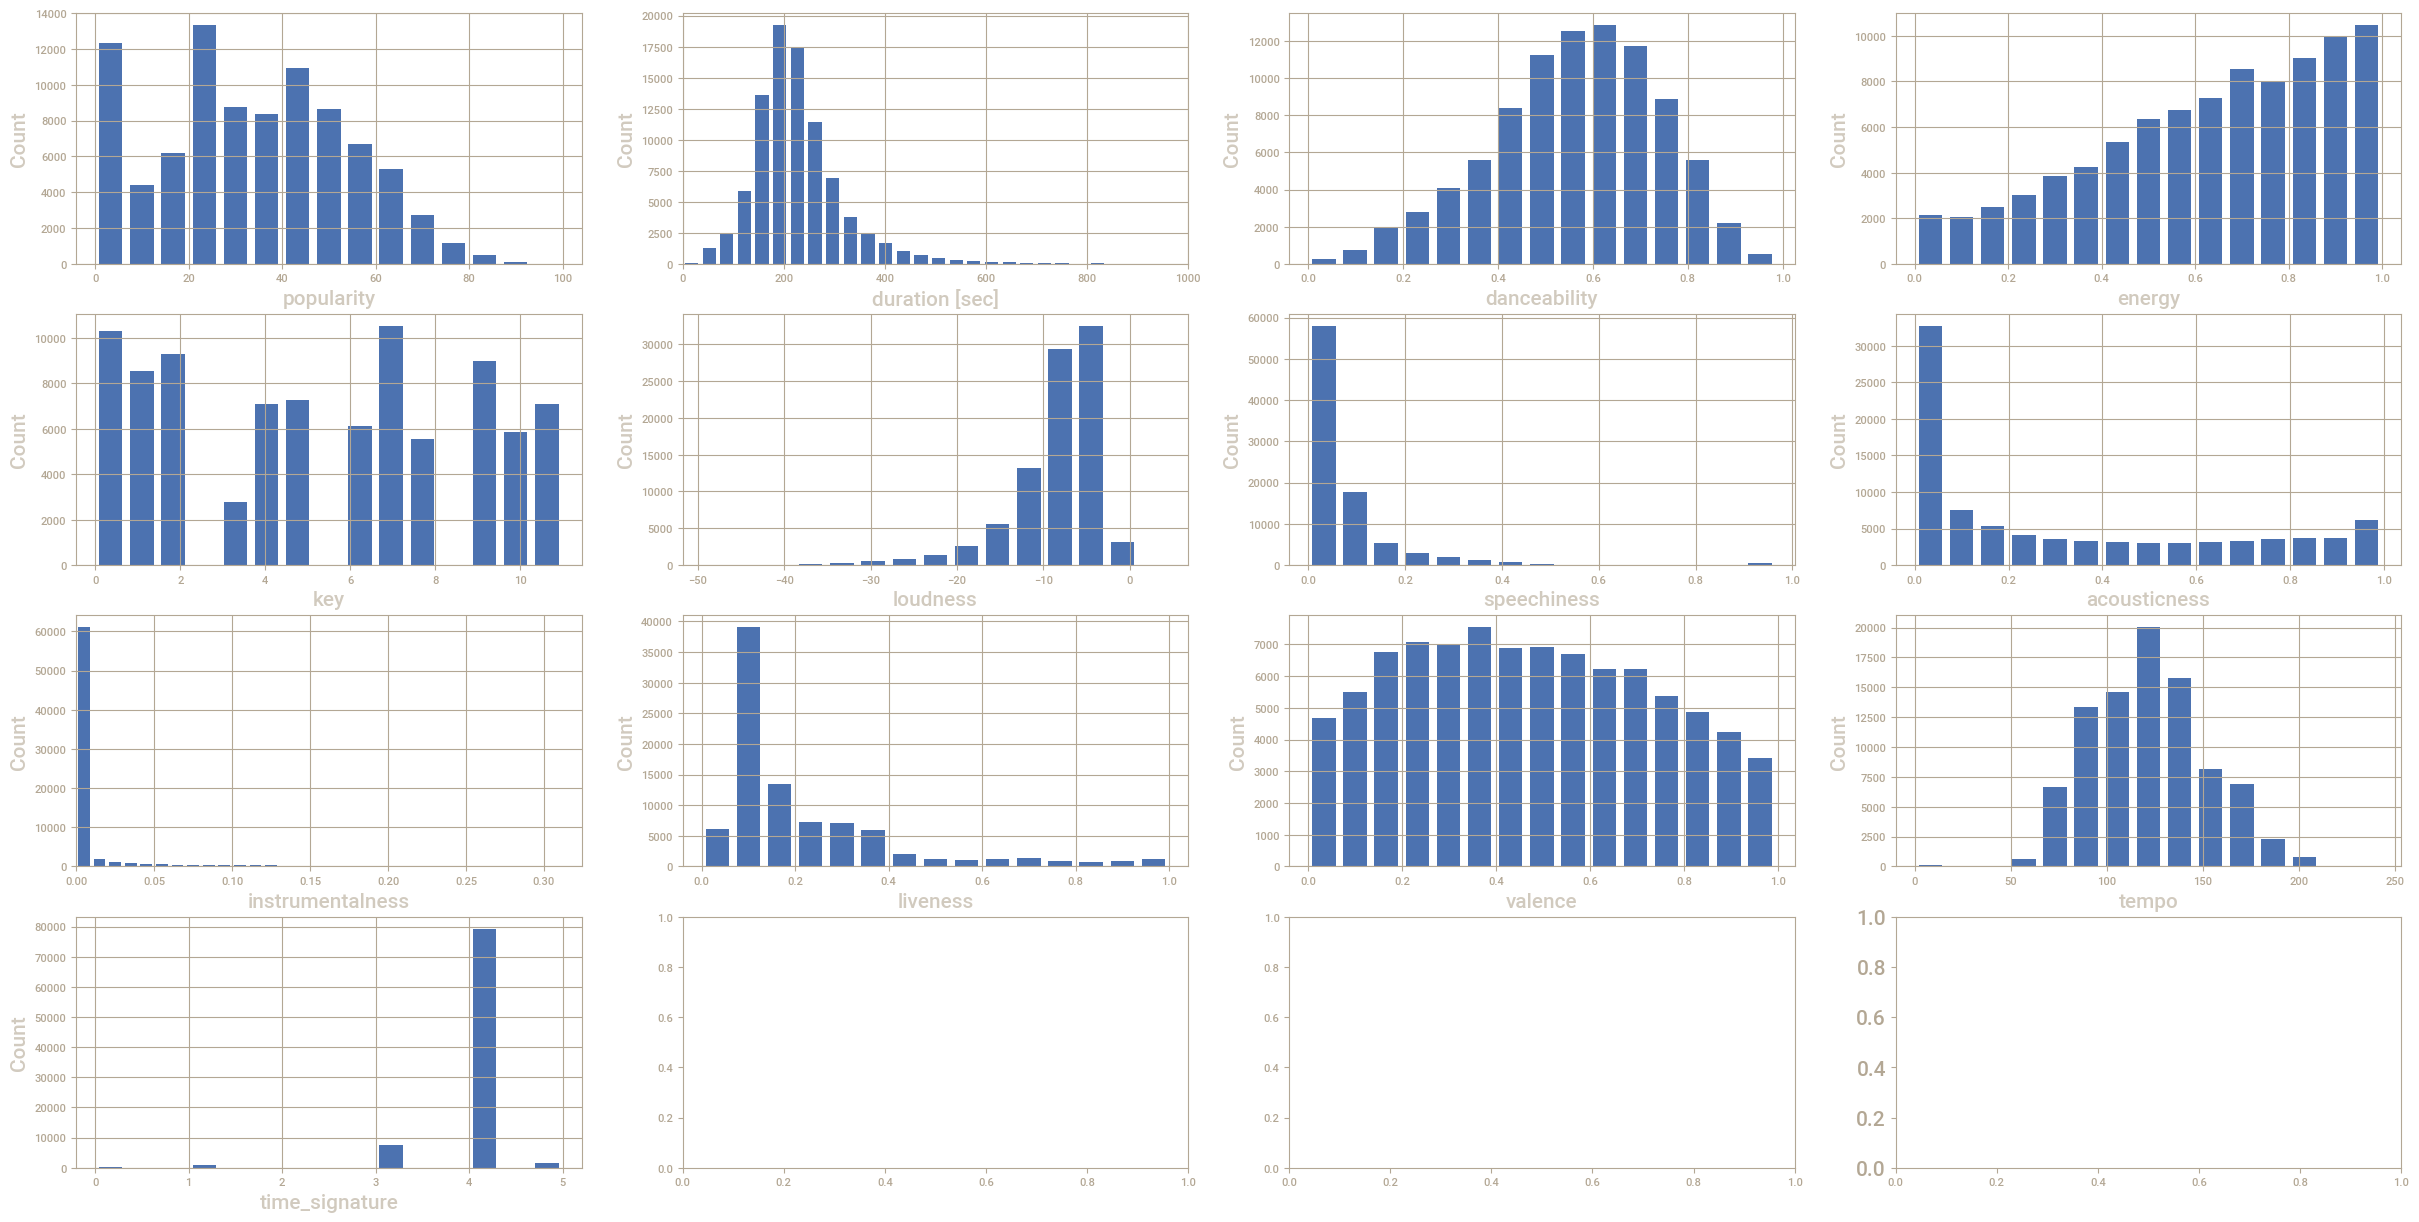

In [319]:
# COLUMN HISTOGRAMS
mpl.style.use('seaborn-deep')

rows = 4
cols = 4
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (30,15))

columns = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

counter = 0
for row in range(rows):
    for col in range(cols):
        if counter <= len(columns) - 1:
            ax1[row,col].set_ylabel('Count', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
            ax1[row,col].grid(True)
            if columns[counter] != 'duration_ms' and columns[counter] != 'instrumentalness':
                ax1[row,col].set_xlabel(columns[counter], fontsize = 15, fontweight = 'bold', alpha = 0.6)
                ax1[row,col].hist(x= df[columns[counter]], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
            elif columns[counter] == 'duration_ms':
                ax1[row,col].set_xlabel('duration [sec]', fontsize = 15, fontweight = 'bold', alpha = 0.6)
                ax1[row,col].hist(x= df[columns[counter]]/1000, bins=150, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
                ax1[row,col].set_xlim(0,1000)
            else:
                ax1[row,col].set_xlabel('instrumentalness', fontsize = 15, fontweight = 'bold', alpha = 0.6)
                ax1[row,col].hist(x= df[columns[counter]], bins=100, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
                ax1[row,col].set_xlim(0,df.instrumentalness.median() + df.instrumentalness.std())
            
            counter += 1

plt.yticks(fontsize = 15)


Values for speechiness, instrumentalness and time_signature seem to be fairly constant for the entire dataset, so they probably won't be useful for the analysis.
Based on distribution alone:
- Primary variables to consider: duration, danceability, energy, key, valence, tempo
- Secondary variables to consider: loudness, acousticeness, liveness

In [320]:
print (f'Instrumentalness median = {df.instrumentalness.median()}')
print (f'Instrumentalness max = {df.instrumentalness.max()}')
print (f'Instrumentalness min = {df.instrumentalness.min()}')
print (f'Instrumentalness mean = {round(df.instrumentalness.mean(),3)}')
print (f'Instrumentalness std = {round(df.instrumentalness.std(),3)}')

Instrumentalness median = 5.8e-05
Instrumentalness max = 1.0
Instrumentalness min = 0.0
Instrumentalness mean = 0.174
Instrumentalness std = 0.324


In [321]:
print(df[df['explicit'] == True].track_id.count())
print(df[df['explicit'] == False].track_id.count())

print(df[df['mode'] == 0].track_id.count())
print(df[df['mode'] == 1].track_id.count())


7690
81800
32482
57008


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\309257735.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


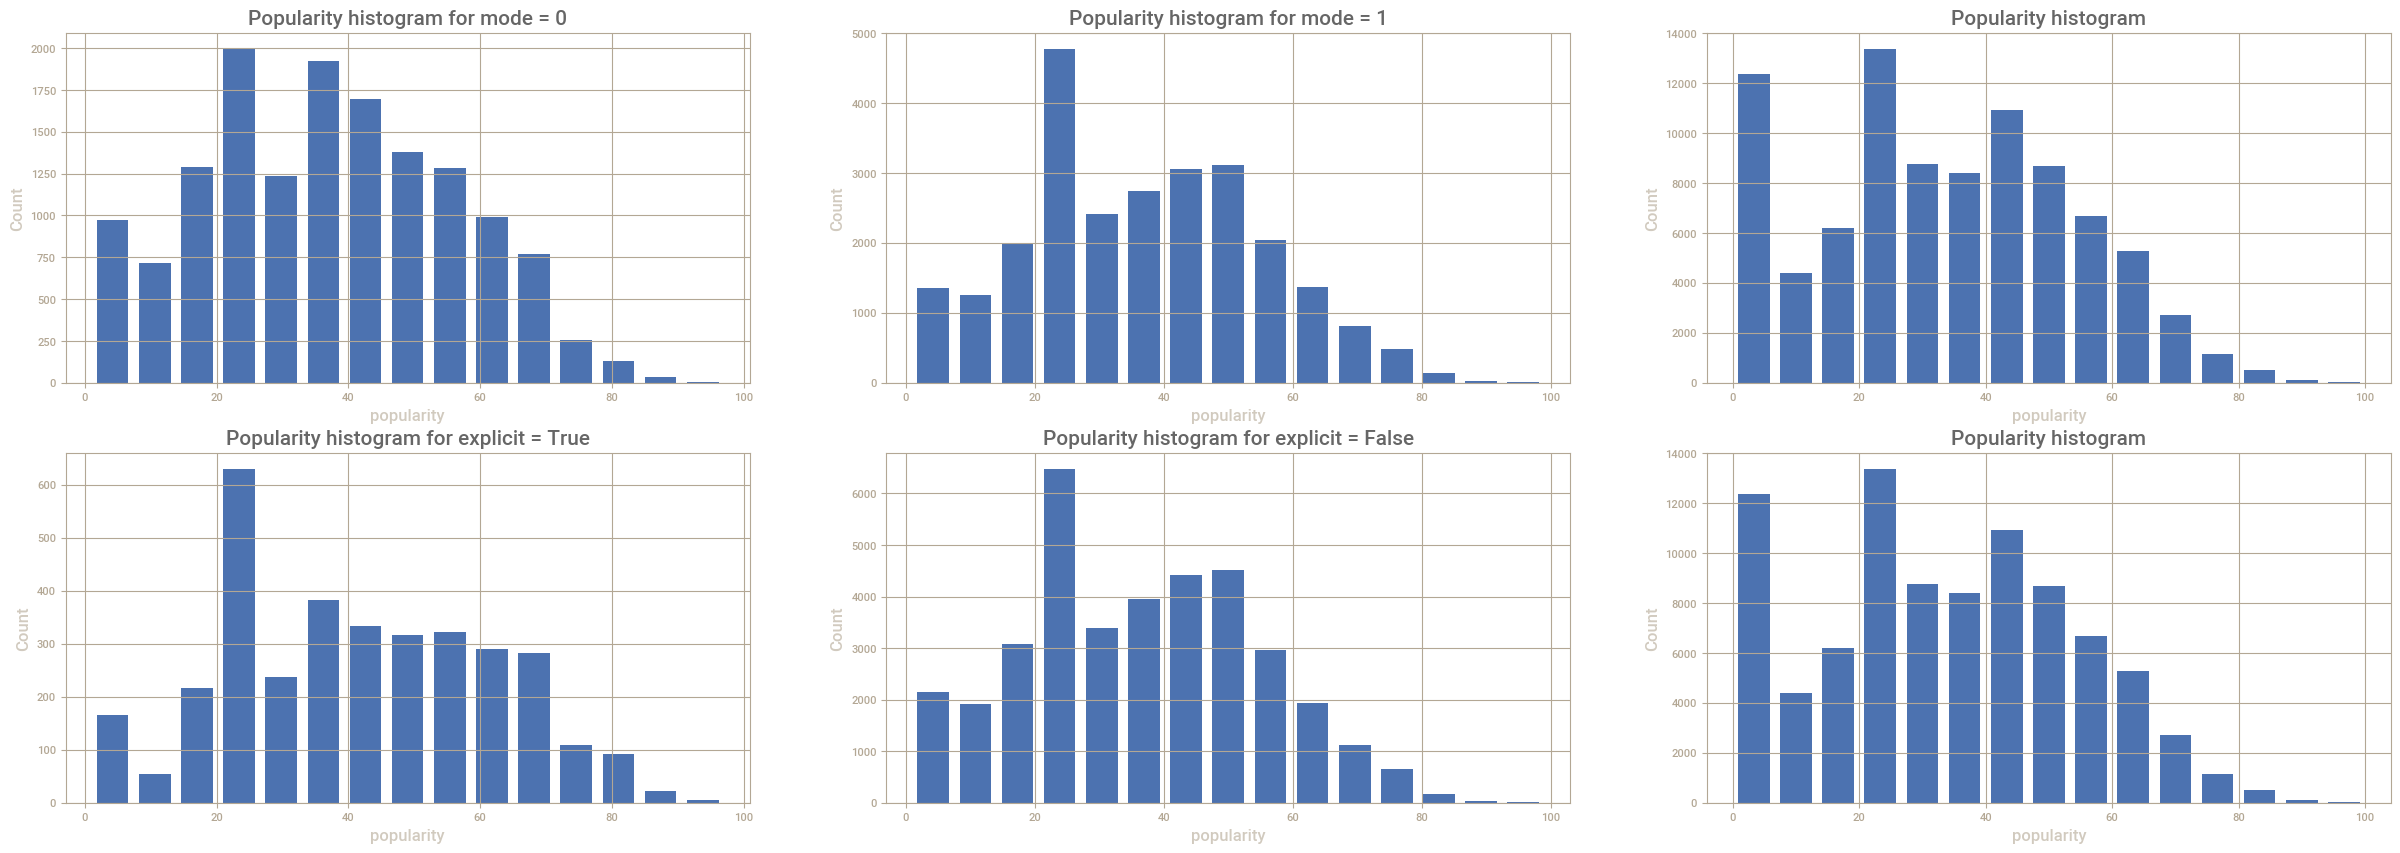

In [322]:
# POPULARITY HISTOGRAMS FOR 'MODE' AND 'EXPLICIT' VALUES
mpl.style.use('seaborn-deep')
fig,ax1 = plt.subplots(nrows = 2, ncols = 3, figsize = (30,10))


# POPULARITY HISTOGRAMS FOR 'MODE' 1 AND 0
ax1[0,0].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[0,0].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
df_mode = df[(df['popularity']) & (df['mode'] == 0)]
ax1[0,0].hist(x= df_mode['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[0,0].set_title ('Popularity histogram for mode = 0', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[0,0].grid(True)

ax1[0,1].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[0,1].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
df_mode = df[(df['popularity']) & (df['mode'] == 1)]
ax1[0,1].hist(x= df_mode['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[0,1].set_title ('Popularity histogram for mode = 1', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[0,1].grid(True)

ax1[0,2].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[0,2].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[0,2].hist(x= df['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[0,2].set_title ('Popularity histogram', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[0,2].grid(True)

# POPULARITY HISTOGRAMS FOR 'EXPLICIT' TRUE AND FALSE
ax1[1,0].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[1,0].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
df_mode = df[(df['popularity']) & (df['explicit'] == True)]
ax1[1,0].hist(x= df_mode['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[1,0].set_title ('Popularity histogram for explicit = True', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[1,0].grid(True)

ax1[1,1].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[1,1].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
df_mode = df[(df['popularity']) & (df['explicit'] == False)]
ax1[1,1].hist(x= df_mode['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[1,1].set_title ('Popularity histogram for explicit = False', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[1,1].grid(True)

ax1[1,2].set_ylabel('Count', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
ax1[1,2].set_xlabel('popularity', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[1,2].hist(x= df['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75)
ax1[1,2].set_title ('Popularity histogram', fontsize = 15, fontweight = 'bold', alpha = 0.6)
ax1[1,2].grid(True)


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\3417914881.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

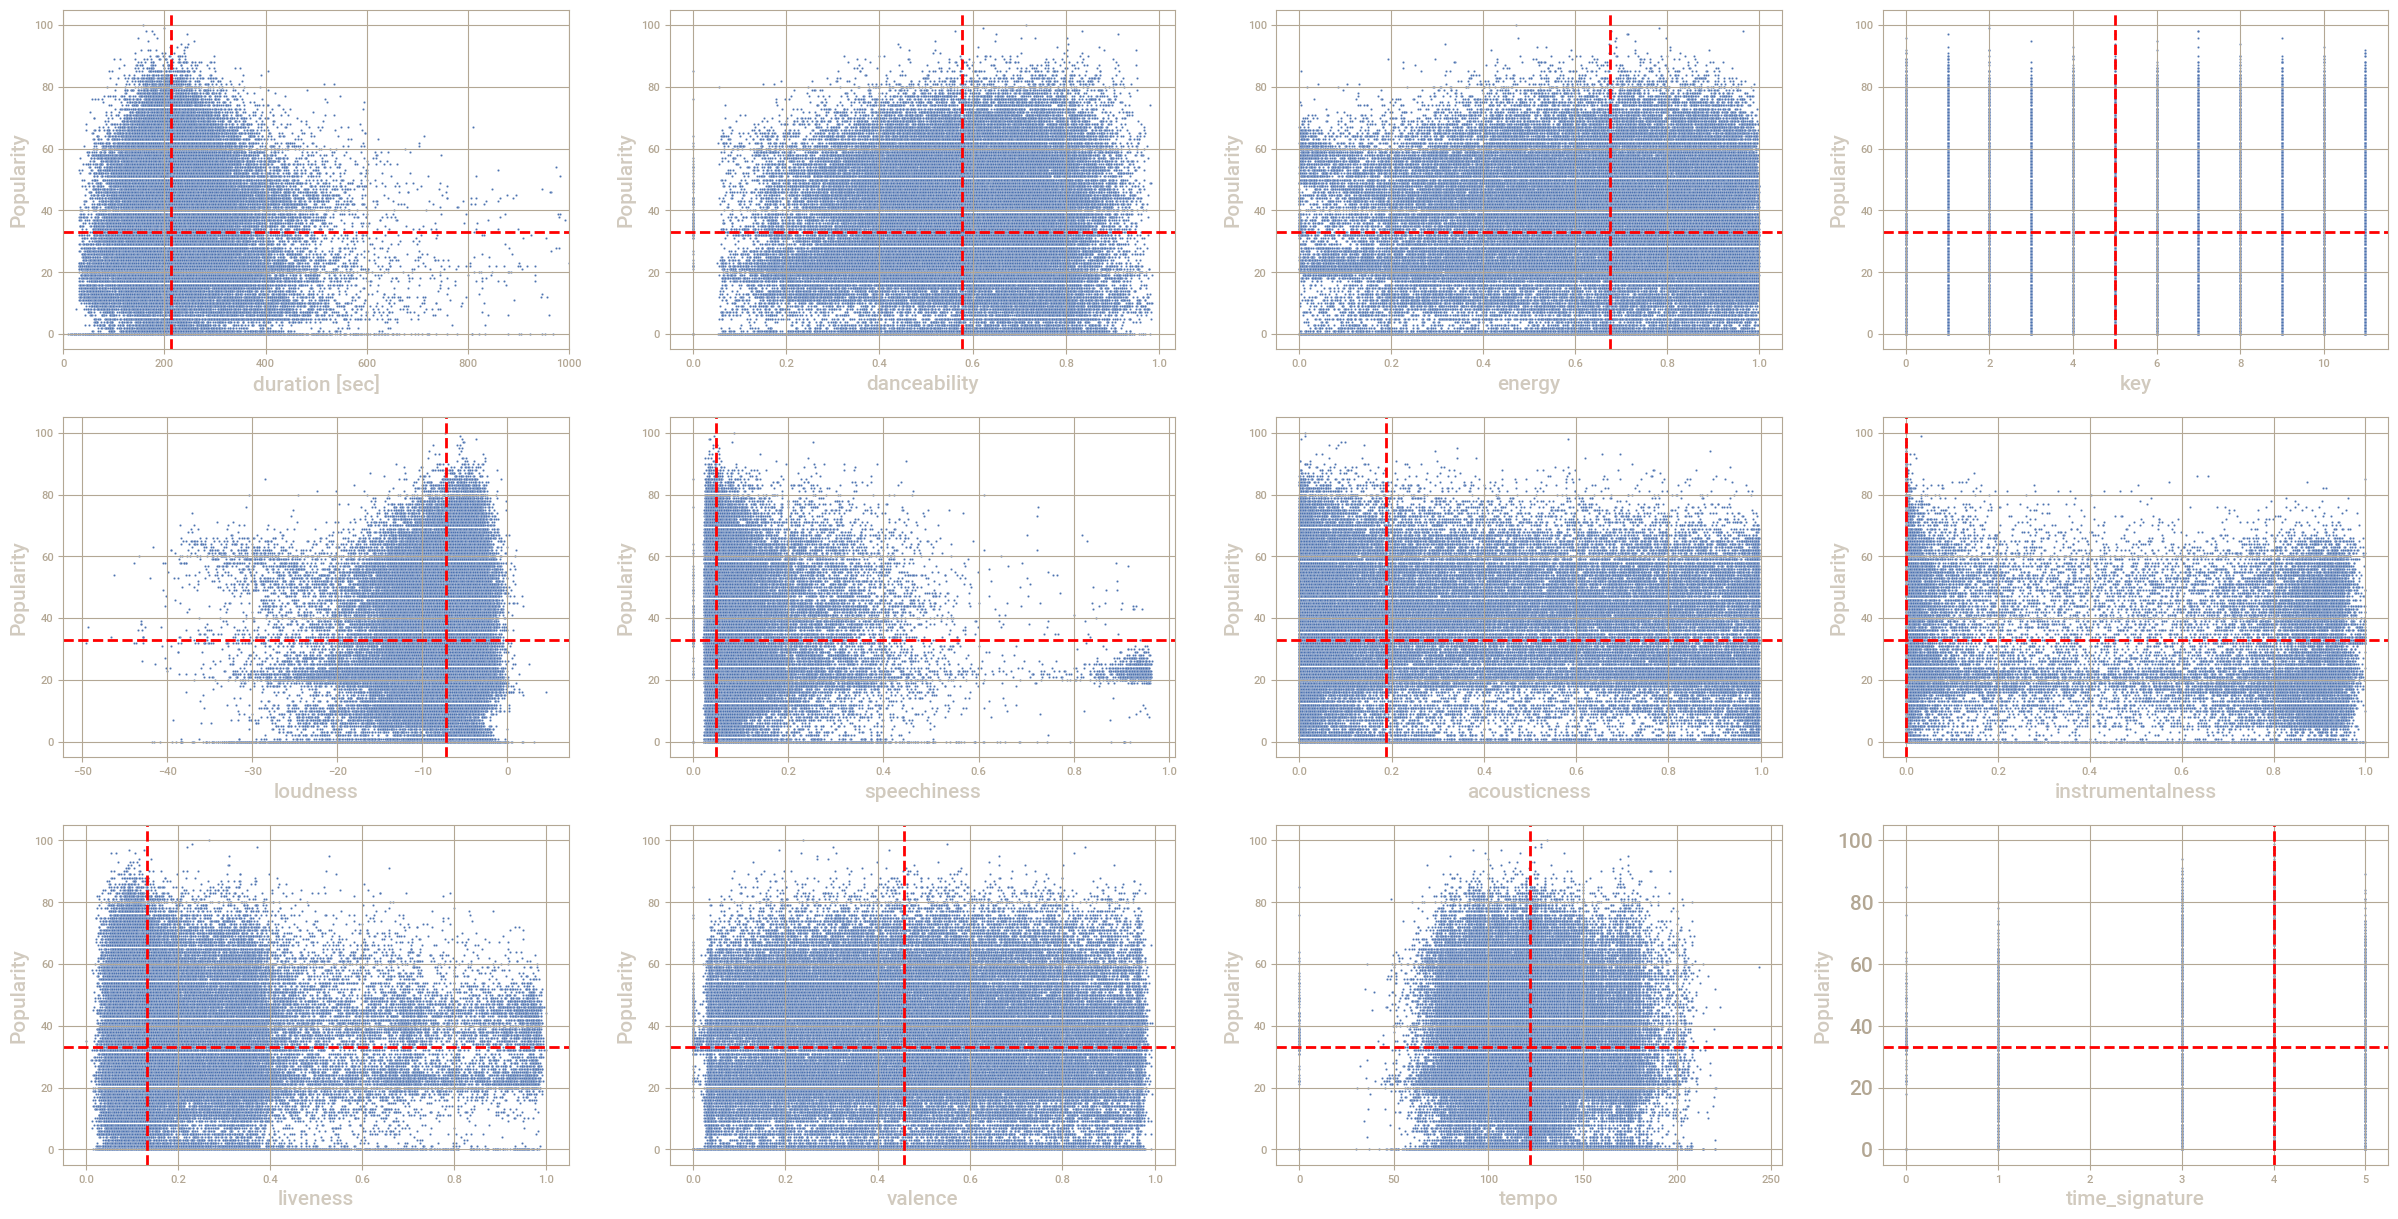

In [323]:
# SCATTERPLOTS
mpl.style.use('seaborn-deep')

rows = 3
cols = 4
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (30,15))

columns = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

counter = 0
for row in range(rows):
    for col in range(cols):
        if counter <= len(columns) - 1:
            ax1[row,col].set_ylabel('Popularity', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
            #ax1[row,col].set_title ('Popularity as a function of ' + columns[counter], fontsize = 10, fontweight = 'bold', alpha = 0.6)
            ax1[row,col].grid(True)
            ax1[row,col].axhline(y = df.popularity.median(), c='red', ls='--', lw=2)
            if columns[counter] != 'duration_ms':
                sns.scatterplot(ax = ax1[row,col], data = df, x= df[columns[counter]], y = df['popularity'], s = 2.5)
                ax1[row,col].set_xlabel(columns[counter], fontsize = 15, fontweight = 'bold', alpha = 0.6)
                ax1[row,col].axvline(x = df[columns[counter]].median(), c='red', ls='--', lw=2)
            else:
                sns.scatterplot(ax = ax1[row,col], data = df, x= df[columns[counter]]/1000, y = df['popularity'], s = 2.5)
                ax1[row,col].set_xlabel('duration [sec]', fontsize = 15, fontweight = 'bold', alpha = 0.6)
                ax1[row,col].set_xlim(0,1000)
                ax1[row,col].axvline(x = df[columns[counter]].median()/1000, c='red', ls='--', lw=2)
            
            counter += 1

plt.yticks(fontsize = 15)


Even though lower values of popularity can be seen for a wide range of the remaining variables, higher values of popularity seem to be achieved for tracks with:
- Higher values of danceability, energy and time_signature
- Values of duration, loudness, speechiness, liveness and time signature close to median values
- Lower values of speechiness, acousticeness, instrumentalness, and liveness

This is also aligned with what is shown in popularity histogram, as the second highest popularity range is close to zero (close to 12000 values). Therefore, it might be better to define and predict a track popularity range, rather than it's popularity rating.

In [324]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,89490.000000,8.949000e+04,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000,89490.000000
mean,33.203408,2.291463e+05,0.562086,0.634375,5.282925,-8.501198,0.637032,0.087492,0.328445,0.173665,0.216857,0.469235,122.057403,3.897273
std,20.562145,1.130538e+05,0.176743,0.256680,3.559959,5.225774,0.480858,0.113380,0.338431,0.324047,0.194691,0.262869,30.116513,0.453871
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.729862e+05,0.450000,0.457000,2.000000,-10.325750,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.269000,4.000000
50%,33.000000,2.132795e+05,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000,4.000000
75%,49.000000,2.643068e+05,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.626000,0.098175,0.279000,0.682000,140.074750,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


# **FEATURE SELECTION**

### **MUTUAL INFORMATION**

C:\Users\velas\AppData\Local\Temp\ipykernel_19128\1512037674.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


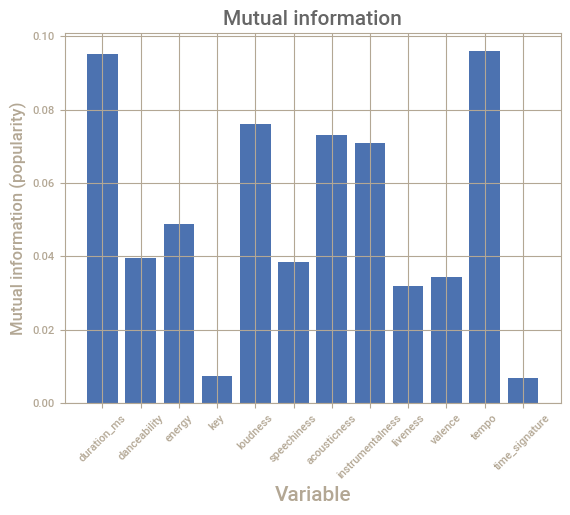

In [325]:
x = df[columns]
y = df.popularity

mi = mutual_info_regression (X = x, y = y) # look for any kind of relationship between features and targer variables

mpl.style.use('seaborn-deep')

plt.bar(df[columns].columns, mi)

plt.xlabel ('Variable', fontsize = 15, fontweight = 'bold', alpha = 1)
plt.ylabel ('Mutual information (popularity)', fontsize = 12, fontweight = 'bold', alpha = 1)
plt.title ('Mutual information', fontsize = 15, fontweight = 'bold', alpha = 0.6)
plt.xticks (rotation = 45)
plt.grid(True)


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\2041513104.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


<AxesSubplot: title={'center': 'Energy as a function of acousticness'}, xlabel='acousticness', ylabel='energy'>

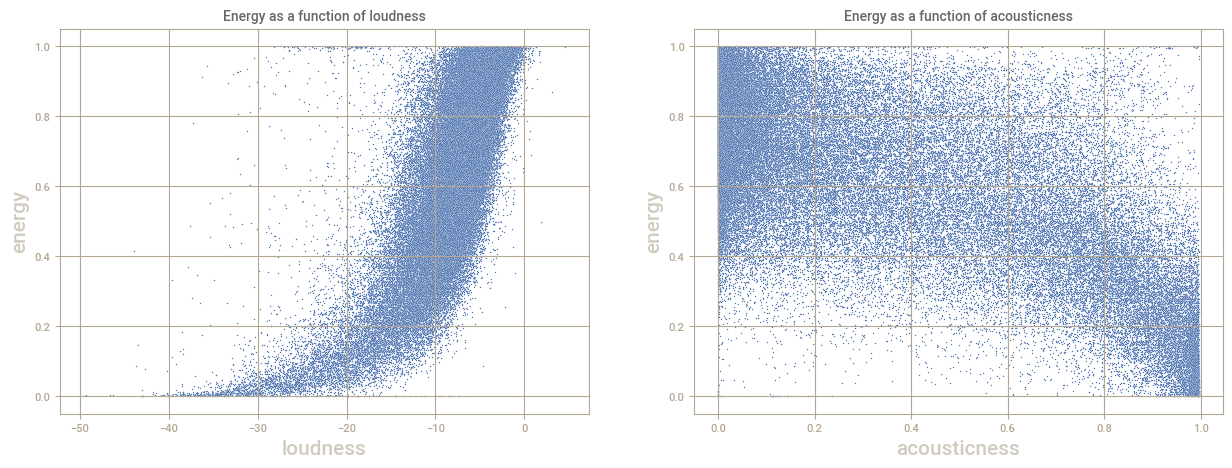

In [326]:
mpl.style.use('seaborn-deep')

fig,ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax1[0].set_ylabel('energy', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_xlabel('loudness', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_title ('Energy as a function of loudness', fontsize = 10, fontweight = 'bold', alpha = 0.6)
ax1[0].grid(True)
sns.scatterplot(ax = ax1[0], data = df, x= df['loudness'], y = df['energy'], s = 1)

ax1[1].set_ylabel('energy', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_xlabel('acousticness', fontsize = 15, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_title ('Energy as a function of acousticness', fontsize = 10, fontweight = 'bold', alpha = 0.6)
ax1[1].grid(True)
sns.scatterplot(ax = ax1[1], data = df, x= df['acousticness'], y = df['energy'], s = 1)

The only variables that appear to be correlated are loudness and acousticness with energy, even though the correlation is not considered to be sufficiently good to eliminate any of the variables

<div>
<img src="routemap.png" width="750"/>
</div


### **PCA**

In [327]:
columns = df.columns.to_list()

# Remove columns with strings as well as target variable
columns.pop(columns.index('popularity'))
columns.pop(columns.index('track_id'))
columns.pop(columns.index('artists')) # PENDING ENCODING
columns.pop(columns.index('album_name')) 
columns.pop(columns.index('track_name'))
columns.pop(columns.index('explicit')) 
columns.pop(columns.index('track_genre')) # PENDING ENCODING

# Generate arrays with input and target variables
df_data = df[columns]
df_target = df['popularity'].to_numpy()

# Data scaling
df_data_scaled = StandardScaler().fit_transform(df_data)

In [328]:
# Auxiliary function to parametrically name columns of principal components 
def PC (list):
    for element in list:
        list[list.index(element)] = 'PC' + str(element)
    return list

ncomp = 0.9 # Define desired number of components (ncomp > 1) or desired explained variance (0 < ncomp < 1)

# PCA
pca = PCA (n_components = ncomp, svd_solver = 'full')
pca_features = pca.fit_transform (df_data_scaled)

print (f'Shape before PCA: {df_data_scaled.shape}')
print (f'Shape after PCA: {pca_features.shape}')
print (f'Percentage of variance explained: {round(100*pca.explained_variance_ratio_.cumsum()[-1],1)}%')

cols = PC(list(range(1, len(pca_features[0]) + 1)))
pca_df = pd.DataFrame (data = pca_features, columns = cols)

pca_df.head()

Shape before PCA: (89490, 13)
Shape after PCA: (89490, 10)
Percentage of variance explained: 93.0%


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.731142,-0.861959,-0.421962,0.631962,1.257418,0.510008,-1.299617,-0.256027,1.011248,-0.347636
1,3.164783,-1.485966,-0.341657,-0.956209,0.582340,0.078509,-0.125337,-0.910877,0.539075,0.983752
2,1.351640,-0.016631,-0.061890,-1.339374,0.872789,0.793427,-0.682996,-1.256913,0.159522,1.258595
3,3.631844,0.140706,-0.749577,-2.115341,-1.609736,-0.976871,-0.299087,1.741200,1.199978,0.643043
4,0.892701,-0.470233,0.321442,-1.148616,0.277702,-0.132119,-0.174698,-0.288861,0.128335,1.023148


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\1269648483.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


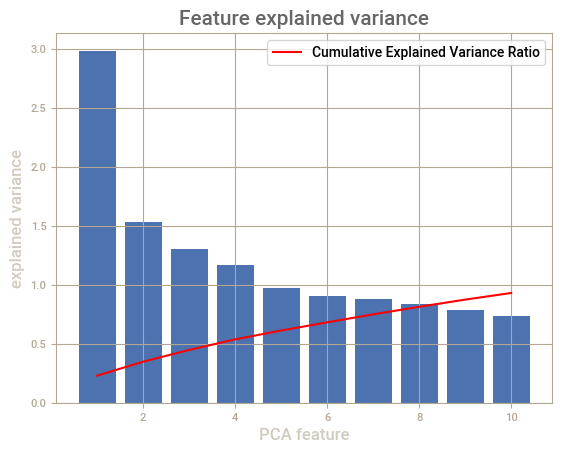

In [329]:
mpl.style.use('seaborn-deep')

plt.bar(range(1,len(pca.explained_variance_) + 1), pca.explained_variance_)

plt.xlabel ('PCA feature', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
plt.ylabel ('explained variance', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
plt.title ('Feature explained variance', fontsize = 15, fontweight = 'bold', alpha = 0.6)

plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), c = 'red', label = 'Cumulative Explained Variance Ratio')
plt.legend (loc = 'upper right')
plt.grid (True)

# **MODELS**

### **DEFINITION**

In [330]:
print (f"There are {(df['popularity'].value_counts() == 1).sum()} popularity ratings with only one appearance") # Cannot stratify data when splitting in test and train dataset.

# Model with features from PCA
x_PCA = pca_df
y_PCA = df.popularity

x_train_PCA, x_val_PCA, y_train_PCA, y_val_PCA = train_test_split(x_PCA, y_PCA, test_size = 0.2, random_state=0) # split dataset into test and train dataset

reg_PCA = SGDRegressor(max_iter=1000, random_state=0) # Stochastic gradient regression

reg_PCA.fit(x_train_PCA, y_train_PCA)

predic_PCA = reg_PCA.predict(x_val_PCA)
predic_PCA_train = reg_PCA.predict(x_train_PCA)


# Model with all features except track_id, artists, album_name, track_name, explicit and track_genre
df_data_scaled_df = pd.DataFrame(data=df_data_scaled, columns=columns)
x_all = df_data_scaled_df
y_all = df.popularity

x_train_all, x_val_all, y_train_all, y_val_all = train_test_split(x_all, y_all, test_size = 0.2, random_state=0) # split dataset into test and train dataset

reg_all = SGDRegressor(max_iter=1000, random_state=0) # Stochastic gradient regression

reg_all.fit(x_train_all, y_train_all)

predic_all = reg_all.predict(x_val_all)
predic_all_train = reg_all.predict(x_train_all)

There are 2 popularity ratings with only one appearance


### **EVALUATION**

C:\Users\velas\AppData\Local\Temp\ipykernel_19128\3671463972.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')
C:\Users\velas\AppData\Local\Temp\ipykernel_19128\3671463972.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = y_val_PCA[ini:fin], s = 2.5, c = 'b', label = 'Real values')
C:\Users\velas\AppData\Local\Temp\ipykernel_19128\3671463972.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-

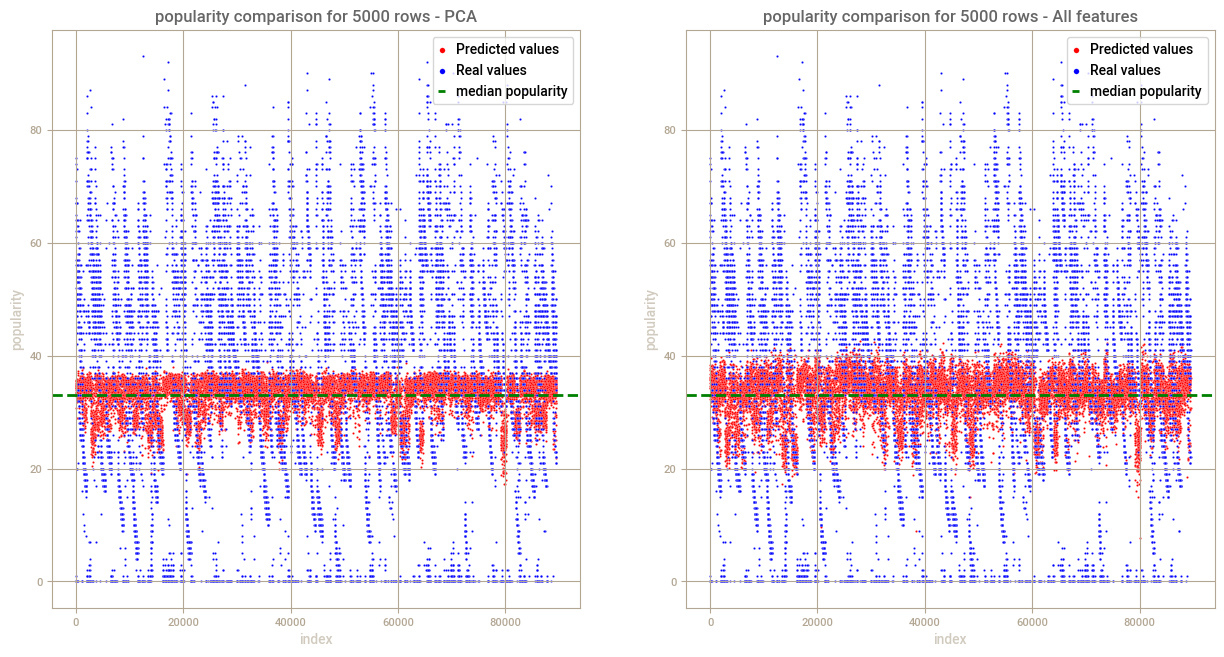

In [331]:
# Visualization of predicted vs real values
mpl.style.use('seaborn-deep')
fig,ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7.5))
ini = 0 # first index to plot
fin = 20000 # final index to plot

# PCA Model
ax1[0].set_ylabel('popularity', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_xlabel('index', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_title ('popularity comparison for 5000 rows - PCA', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[0].grid(True)
sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = predic_PCA[ini:fin], s = 2.5, c = 'r', label = 'Predicted values')
sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = y_val_PCA[ini:fin], s = 2.5, c = 'b', label = 'Real values')
ax1[0].axhline(y = df.popularity.median(), c='green', ls='--', lw=2, label = 'median popularity')
ax1[0].legend(loc = 'upper right', handlelength = 0.5, markerscale = 2.5)

# Model with all features
ax1[1].set_ylabel('popularity', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_xlabel('index', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_title ('popularity comparison for 5000 rows - All features', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[1].grid(True)
sns.scatterplot(ax = ax1[1], x = x_val_all.index[ini:fin], y = predic_all[ini:fin], s = 2.5, c = 'r', label = 'Predicted values')
sns.scatterplot(ax = ax1[1], x = x_val_all.index[ini:fin], y = y_val_all[ini:fin], s = 2.5, c = 'b', label = 'Real values')
ax1[1].axhline(y = df.popularity.median(), c='green', ls='--', lw=2, label = 'median popularity')
ax1[1].legend(loc = 'upper right', handlelength = 0.5, markerscale = 2.5)



### **CONCLUSION**

Until now, regression models for all features, as well as models considering features obtained by PCA, seem to perform very poorly. Even though the error decreases when more variables are considered, the best explained variance so far is 3.08%, which is inadmissible. This is also seen when plotting real vs predicted values.
It appears that the model could be underfitting the actual data, as the error for training and validation sets are similar.


Possible future actions include:
- Encode categorical variable track_genre and artists and include them in the analysis
- Try eliminating zero popularity ratings
- Try different and more complex regression models
- Fine tune model parameters
- Train model for a longer period of time

In [333]:
# Model without zero popularity values
print (df[df['popularity']==0].track_id.count())

# Copy dataframe and remove zero popualrity ratings
df_copy = df.copy()
df_copy.drop((df_copy[df_copy['popularity'] == 0]).index, inplace = True)

# Data scaling
df_copy_data = df_copy[columns]
df_copy_data_scaled = StandardScaler().fit_transform(df_copy_data)

# Model creation
df_copy_data_scaled_df = pd.DataFrame(data=df_copy_data_scaled, columns=columns)
x = df_copy_data_scaled_df
y = df_copy.popularity

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=0) # split dataset into test and train dataset

reg = SGDRegressor(max_iter=1000, random_state=0) # Stochastic gradient regression

reg.fit(x_train, y_train)

predic = reg.predict(x_val)
predic_train = reg.predict(x_train)

9338


C:\Users\velas\AppData\Local\Temp\ipykernel_19128\4082671287.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')
C:\Users\velas\AppData\Local\Temp\ipykernel_19128\4082671287.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = y_val_PCA[ini:fin], s = 2.5, c = 'b', label = 'Real values')
C:\Users\velas\AppData\Local\Temp\ipykernel_19128\4082671287.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-

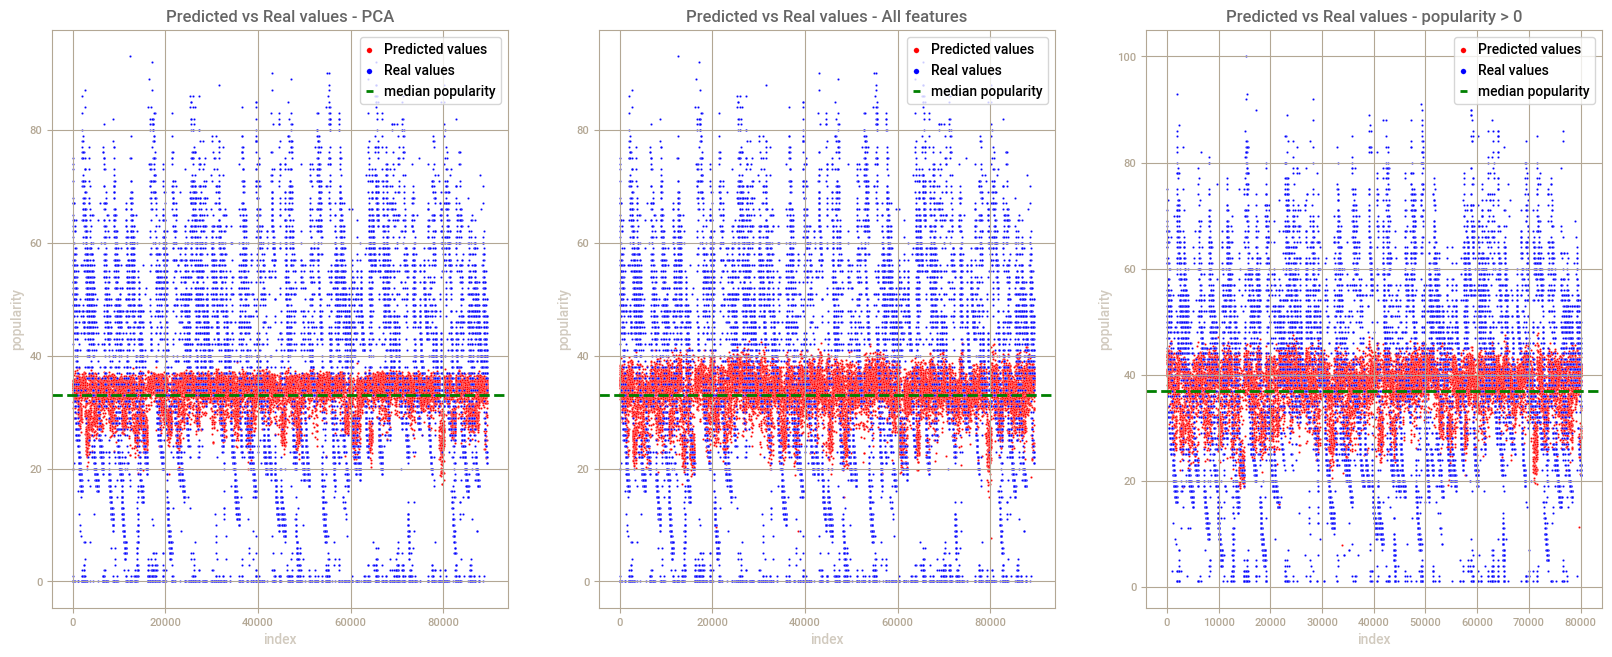

In [334]:
# Visualization of predicted vs real values
mpl.style.use('seaborn-deep')
fig,ax1 = plt.subplots(nrows = 1, ncols = 3, figsize = (20,7.5), sharey = False)
ini = 0 # first index to plot
fin = 20000 # final index to plot

# PCA Model
ax1[0].set_ylabel('popularity', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_xlabel('index', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[0].set_title ('Predicted vs Real values - PCA', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[0].grid(True)
sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = predic_PCA[ini:fin], s = 2.5, c = 'r', label = 'Predicted values')
sns.scatterplot(ax = ax1[0], x = x_val_PCA.index[ini:fin], y = y_val_PCA[ini:fin], s = 2.5, c = 'b', label = 'Real values')
ax1[0].axhline(y = df.popularity.median(), c='green', ls='--', lw=2, label = 'median popularity')
ax1[0].legend(loc = 'upper right', handlelength = 0.5, markerscale = 2.5)

# Model with all features
ax1[1].set_ylabel('popularity', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_xlabel('index', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[1].set_title ('Predicted vs Real values - All features', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[1].grid(True)
sns.scatterplot(ax = ax1[1], x = x_val_all.index[ini:fin], y = predic_all[ini:fin], s = 2.5, c = 'r', label = 'Predicted values')
sns.scatterplot(ax = ax1[1], x = x_val_all.index[ini:fin], y = y_val_all[ini:fin], s = 2.5, c = 'b', label = 'Real values')
ax1[1].axhline(y = df.popularity.median(), c='green', ls='--', lw=2, label = 'median popularity')
ax1[1].legend(loc = 'upper right', handlelength = 0.5, markerscale = 2.5)

# Model without zero popularity ratings
ax1[2].set_ylabel('popularity', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[2].set_xlabel('index', fontsize = 10, fontweight = 'bold', alpha = 0.6 )
ax1[2].set_title ('Predicted vs Real values - popularity > 0', fontsize = 12, fontweight = 'bold', alpha = 0.6)
ax1[2].grid(True)
sns.scatterplot(ax = ax1[2], x = x_val.index[ini:fin], y = predic[ini:fin], s = 2.5, c = 'r', label = 'Predicted values')
sns.scatterplot(ax = ax1[2], x = x_val.index[ini:fin], y = y_val[ini:fin], s = 2.5, c = 'b', label = 'Real values')
ax1[2].axhline(y = df_copy.popularity.median(), c='green', ls='--', lw=2, label = 'median popularity')
ax1[2].legend(loc = 'upper right', handlelength = 0.5, markerscale = 2.5)

In [336]:
# PCA Model evaluation

#print (f'----------------------------------------------------\nPCA MODEL METRICS ({ncomp*100}% minimum explained variance) ')
#print(f'- Mean squared error for training dataset = {round(mean_squared_error (y_true = y_train_PCA, y_pred = predic_PCA_train),2)}')
#print(f'- Mean squared error for validation dataset = {round(mean_squared_error (y_true = y_val_PCA, y_pred = predic_PCA),2)}')
print(f'- Mean absolute error for training dataset = {round(mean_absolute_error (y_true = y_train_PCA, y_pred = predic_PCA_train),2)}')
print(f'- Mean absolute error for validation dataset = {round(mean_absolute_error (y_true = y_val_PCA, y_pred = predic_PCA),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train_PCA, y_pred = predic_PCA_train),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val_PCA, y_pred = predic_PCA),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train_PCA, y_pred = predic_PCA_train),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val_PCA, y_pred = predic_PCA),2)}%')

# All features Model evaluation

print ('----------------------------------------------------\nALL FEATURES MODEL METRICS')
#print(f'- Mean squared error for training dataset = {round(mean_squared_error (y_true = y_train_all, y_pred = predic_all_train),2)}')
#print(f'- Mean squared error for validation dataset = {round(mean_squared_error (y_true = y_val_all, y_pred = predic_all),2)}')
print(f'- Mean absolute error for training dataset = {round(mean_absolute_error (y_true = y_train_all, y_pred = predic_all_train),2)}')
print(f'- Mean absolute error for validation dataset = {round(mean_absolute_error (y_true = y_val_all, y_pred = predic_all),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train_all, y_pred = predic_all_train),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val_all, y_pred = predic_all),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train_all, y_pred = predic_all_train),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val_all, y_pred = predic_all),2)}%')

# Model without zero popularity ratings evaluation

print ('----------------------------------------------------\nALL FEATURES MODEL METRICS - POPUALARITY > 0')
#print(f'- Mean squared error for training dataset = {round(mean_squared_error (y_true = y_train, y_pred = predic_train),2)}')
#print(f'- Mean squared error for validation dataset = {round(mean_squared_error (y_true = y_val, y_pred = predic),2)}')
print(f'- Mean absolute error for training dataset = {round(mean_absolute_error (y_true = y_train, y_pred = predic_train),2)}')
print(f'- Mean absolute error for validation dataset = {round(mean_absolute_error (y_true = y_val, y_pred = predic),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train, y_pred = predic_train),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val, y_pred = predic),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train, y_pred = predic_train),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val, y_pred = predic),2)}%')

print ('----------------------------------------------------')

- Mean absolute error for training dataset = 16.91
- Mean absolute error for validation dataset = 16.98
- Max error for training dataset = 66.29
- Max error for validation dataset = 65.5
- Explained variance score for training dataset = 1.86%
- Explained variance score for validation dataset = 2.06%
----------------------------------------------------
ALL FEATURES MODEL METRICS
- Mean absolute error for training dataset = 16.66
- Mean absolute error for validation dataset = 16.73
- Max error for training dataset = 63.73
- Max error for validation dataset = 67.35
- Explained variance score for training dataset = 3.02%
- Explained variance score for validation dataset = 3.08%
----------------------------------------------------
ALL FEATURES MODEL METRICS - POPUALARITY > 0
- Mean absolute error for training dataset = 14.37
- Mean absolute error for validation dataset = 14.38
- Max error for training dataset = 59.86
- Max error for validation dataset = 56.23
- Explained variance score for 

In [144]:
df.shape
df_copy.shape

(80393, 20)